In [126]:
import os

from PIL import Image
import dotenv
import torchvision.transforms as T
import albumentations as A
import numpy as np
import cv2

dotenv.load_dotenv(override=True)

TEMP = os.getenv("TEMP")
if not TEMP:
    raise Exception('Not able to find environment variable')

DATA = os.getenv("DATA")
if not DATA:
    raise Exception('Not able to find environment variable')

In [127]:
temp_files = sorted(os.listdir(TEMP))
len(temp_files)

53

In [128]:
backgound_file = os.path.join(DATA, "coco_test.jpg")

In [362]:
def brightness(img, alpha=None, beta=None):
    if alpha is None:
        alpha = np.random.uniform(0.75, 1.25)
    if beta is None:
        beta = np.random.uniform(-120, 120)

    adjusted_image = alpha * (img.astype(np.float32) + beta)
    return np.clip(adjusted_image, a_min=0, a_max=255).astype(np.uint8), alpha, beta

def get_mask(img):
    mask = np.zeros(img[:,:,:3].shape, np.uint8)
    mask[img[:, :, 3] > 0] = 255
    return mask



def perspective(tmp, mask, x):
    h, w = tmp.shape[0], tmp.shape[1]

    left = x - round(1000 / 2) > 0
    
    p_min, p_max = round(w * 0.07), round(w * 0.14)
    p = np.random.randint(p_min, p_max + 1)
    
    points0 = np.float32([[0, 0], [w - 1, 0], [0, h - 1], [w - 1, h - 1]])
    points1 = (
        np.float32([[p, p], [w - 1, 0], [p, h - 1 - p], [w - 1, h - 1]])
    ) if left else (
        np.float32([[0, 0], [w - 1 - p, p], [0, h - 1], [w - 1 - p, h - 1 - p]])
    )

    m = cv2.getPerspectiveTransform(points0, points1)
    tmp = cv2.warpPerspective(tmp, m, (w, h))
    mask = cv2.warpPerspective(mask, m, (w, h))

    return tmp, mask, p

def rotate(tmp, mask, theta=None):
    if theta is None:
        theta = np.random.uniform(-10, 10)

    # padding to avoid clipping
    pad = max(tmp.shape[:2]) // 2 + 1
    tmp = cv2.copyMakeBorder(tmp, pad, pad, pad, pad, cv2.BORDER_CONSTANT)
    mask = cv2.copyMakeBorder(mask, pad, pad, pad, pad, cv2.BORDER_CONSTANT)
    
    # rotate
    h, w = tmp.shape[0], tmp.shape[1]
    m = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale=1)
    tmp = cv2.warpAffine(tmp, m, (w, h), flags=cv2.INTER_LINEAR)
    mask = cv2.warpAffine(mask, m, (w, h), flags=cv2.INTER_LINEAR)

    # remove padding
    tmp, mask = remove_padding(tmp, mask)

    return tmp, mask, theta


def scale(tmp, mask, relative_x, factor=None):
    if factor is None:
        factor = (0.175 + relative_x) * min(tmp.shape[:2]) / 100
        c = 0
        while min(factor * np.array(tmp.shape[:2])) < 30:
            if c > 100:
                return tmp, mask, 1
            factor = (0.175 + relative_x) * min(tmp.shape[:2]) / 100
            c += 1

    tmp = cv2.resize(tmp, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)

    return tmp, mask, factor


def remove_padding(tmp, mask):
    foregorund = np.argwhere(mask[:,:,0] > 0)
    print(foregorund)
    y0, x0 = foregorund.min(axis=0)
    y1, x1 = foregorund.max(axis=0) + 1

    tmp = tmp[y0:y1, x0:x1]
    mask = mask[y0:y1, x0:x1]

    return tmp, mask


In [363]:
img = cv2.imread(backgound_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

crop_size = min(img.shape[0:2])
img = A.CenterCrop(width=crop_size, height=crop_size)(image=img)['image']
img = A.Resize(width=1000, height=1000)(image=img)['image']

img, alpha, beta = brightness(img)

print(img.shape, img.dtype, alpha, beta)

(1000, 1000, 3) uint8 1.1603554085199685 -3.465859893538507


(69, 69, 3) uint8 (69, 69, 3) 69


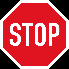

In [370]:
# load
tmp = cv2.imread(os.path.join(TEMP, temp_files[5]), cv2.IMREAD_UNCHANGED)

mask = get_mask(tmp)
tmp = cv2.cvtColor(tmp[:,:,:3], cv2.COLOR_BGR2RGB)

# resize
max_size = np.random.randint(30,100)
tmp = A.LongestMaxSize(max_size=max_size)(image=tmp)['image']
mask = A.LongestMaxSize(max_size=max_size)(image=mask)['image']

# brightness
tmp, _, _ = brightness(tmp, alpha=alpha, beta=0)

print(tmp.shape, tmp.dtype, mask.shape, max_size)

T.ToPILImage()(tmp)

In [371]:
# position

max0 = img.shape[0] - tmp.shape[0]
max1 = img.shape[1] - tmp.shape[1]

pos0 = np.random.randint(0, max0 + 1)
pos1 = np.random.randint(0, max1 + 1)

print(pos1, pos0)

787 113


5
(69, 69, 3)


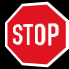

In [372]:
# perspective transformation

tmp, mask, p = perspective(tmp, mask, pos1)

print(p)
print(tmp.shape)

T.ToPILImage()(tmp)

[[ 35  76]
 [ 35  77]
 [ 35  78]
 ...
 [102  81]
 [102  82]
 [102  83]]
(68, 66, 3)


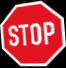

In [373]:
# rotation

tmp, mask, theta = rotate(tmp, mask)

print(tmp.shape)

T.ToPILImage()(tmp)

1.1543400000000001 (78, 76, 3)


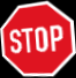

In [374]:
# scale

tmp, mask, factor = scale(tmp, mask, relative_x=abs(2 * pos1 / img.shape[1]))

print(factor, tmp.shape)

T.ToPILImage()(tmp)

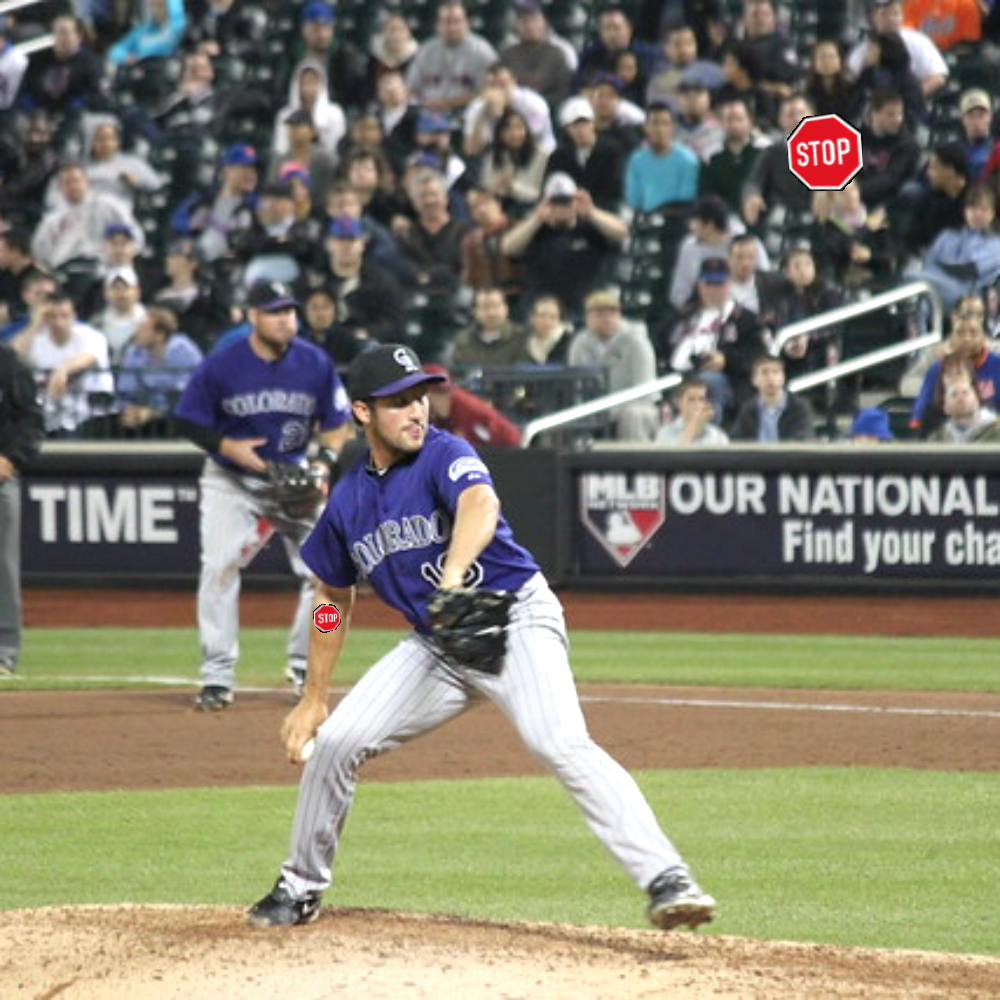

In [375]:
# paste

img[pos0:pos0+tmp.shape[0], pos1:pos1+tmp.shape[1]][mask != 0] = tmp[mask != 0]

T.ToPILImage()(img)